# Token-Wrapped Token Delta

## Ayodeji Adeniyi 13/08/2024
Personal research into efficiency of wrapped tokens, and their market impact,  and possible other uses (i.e., arbitrage oppurtunities, trading positions, and cross-chain liquidity and volume).

Interests include:

Analysis and predictions of price differences, liquidity, and volume of wrapped tokens compared to their native counterparts

Outlok on possible arbitrage opportunities, identifying improvemenmts to trading positions taken during the monitored period

Outlook on the potential for wrapped tokens to become the preferred trading instrument in the bct word and the impact on the market due to the increased cross-chain liquidity and volume

Interactive Plot Handling, and Python - Excel Dashboard curation


The research will be conducted using the following steps:
1.  Data Collection

    Price, Volume, Liquidity of tokens and wrapped versions of interest (BTC, ETH, SOL)

2.  Data Cleaning

    Remove missing values, duplicates, and outliers for time series split (prophet will handle these automatically)

    Compute the returns, volatility, and other metrics for the tokens and their wrapped versions

    Normalize the data to make it comparable

    Create features for machine learning models, such as moving averages, RSI, MACD, Bollinger Bands, and other technical indicators Display the data in a table for analysis

3.  Data Analysis

    Compare the price, volume, and liquidity of the tokens and their wrapped versions

    Conduct time series analysis to identify trends, seasonality, and cycles

    Conduct correlation analysis to identify relationships between the tokens and their wrapped versions

    Conduct regression analysis to identify the impact of the tokens on their wrapped versions

    Conduct sentiment analysis to identify the impact of news and events on the tokens and their wrapped versions

    Conduct ARIMA models on price, volume, and liquidity to predict future values

    Splite time series data into training and testing sets using time series split method, and monte carlo cross validation separately

    Train machine learning models on the training data to predict future values

    Evaluate the models using the testing data to identify the best model

4.  Data Visualization

    Create interactive charts and graphs to visualize the data using matplotlib, plotly and dash

5.  Conclusion

    Summarize the findings and provide recommendations based on the analysis

    Identify the limitations of the research and propose future work

    Provide the data, code, and results for reproducibility

The data will be collected from the following sources:
Coinbase and Kraken.  The data will be collected using the APIs provided by the exchanges.  The data will be collected in real-time and stored in a database for analysis.


Kraken API pairs all assetpairs url
https://api.kraken.com/0/public/AssetPairs

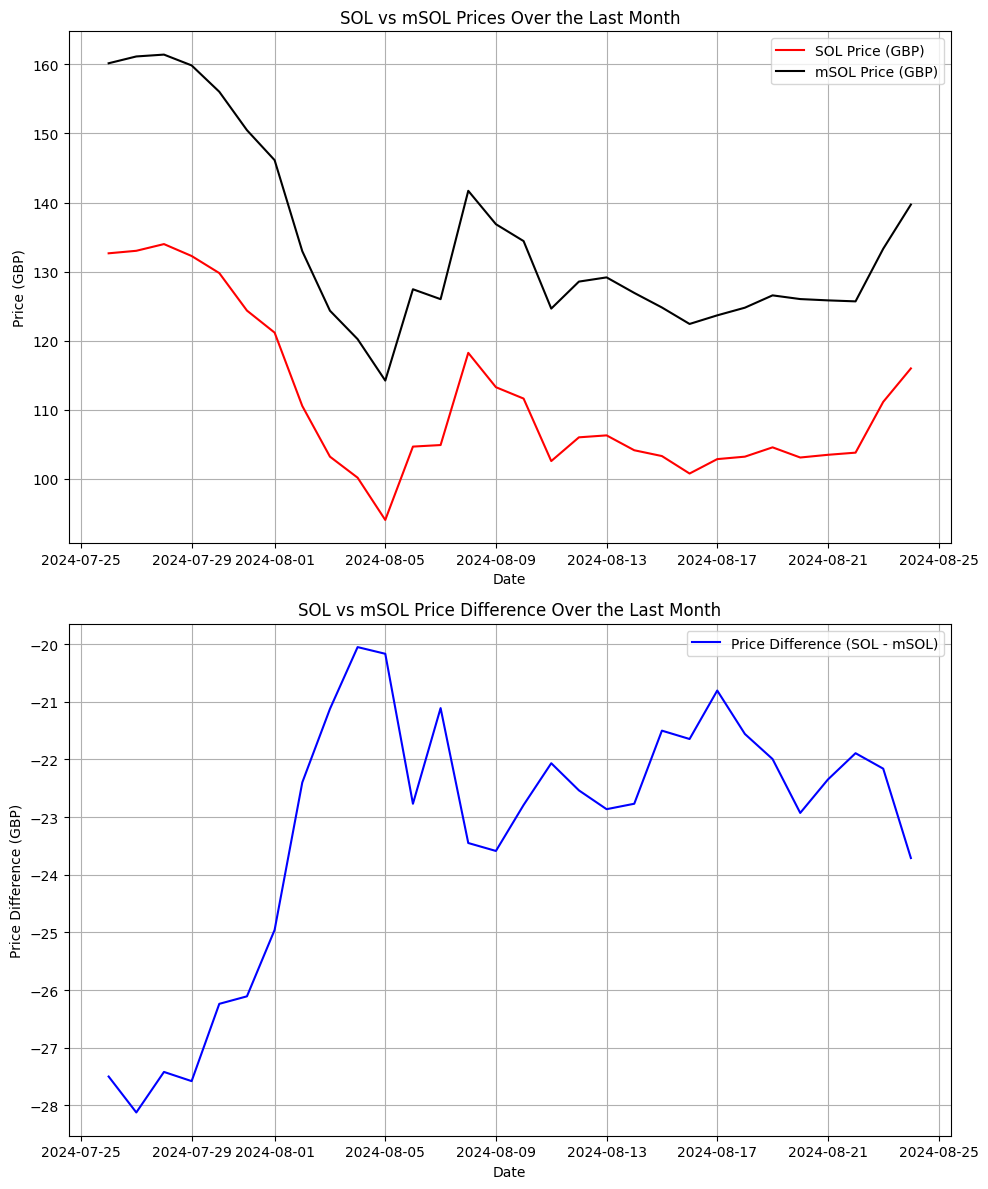

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Coinbase API endpoint
BASE_URLC = 'https://api.pro.coinbase.com'

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "CB-ACCESS-KEY": "MY_API_KEY"
}

# Define the GBP/USD conversion rate
GBP_USD_RATE = 1.38  # Example conversion rate

# Function to fetch historical data from Coinbase
def fetch_hist_data(product_id, start, end, interval):
    url = f"{BASE_URLC}/products/{product_id}/candles"
    params = {
        "start": start,
        "end": end,
        "granularity": interval  # 86400 corresponds to daily candles
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        print(f"No data fetched for {product_id}")
        return pd.DataFrame()
    return pd.DataFrame(data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])

# Define the time ranges (1 month)
end = datetime.utcnow()
start = end - timedelta(days=30)

# Fetch the data for SOL-USD and MSOL-USD for the last month
sol_data = fetch_hist_data("SOL-USD", start.isoformat(), end.isoformat(), 86400)
msol_data = fetch_hist_data("MSOL-USD", start.isoformat(), end.isoformat(), 86400)

# Check if data is fetched correctly
if sol_data.empty or msol_data.empty:
    print("Failed to fetch data for one or both products.")
else:
    # Convert 'time' column to datetime
    sol_data['time'] = pd.to_datetime(sol_data['time'], unit='s')
    msol_data['time'] = pd.to_datetime(msol_data['time'], unit='s')

    # Convert USD prices to GBP
    sol_data['close'] = sol_data['close'] / GBP_USD_RATE
    msol_data['close'] = msol_data['close'] / GBP_USD_RATE

    # Calculate the difference in closing prices
    data = pd.merge(sol_data[['time', 'close']], msol_data[['time', 'close']], on='time', suffixes=('_sol', '_msol'))
    data['price_difference'] = data['close_sol'] - data['close_msol']

    # Plot the data in subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subplot 1: SOL vs mSOL Prices
    axs[0].plot(data['time'], data['close_sol'], label='SOL Price (GBP)', color='red')
    axs[0].plot(data['time'], data['close_msol'], label='mSOL Price (GBP)', color='black')
    axs[0].set_title('SOL vs mSOL Prices Over the Last Month')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (GBP)')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Price Difference
    axs[1].plot(data['time'], data['price_difference'], label='Price Difference (SOL - mSOL)', color='blue')
    axs[1].set_title('SOL vs mSOL Price Difference Over the Last Month')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price Difference (GBP)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
import requests
import pandas as pd
import plotly.graph_objs as go
import pytz

# Function to fetch OHLC data from Kraken API
def fetch_kraken_ohlc(pair, interval=1):
    url = f"https://api.kraken.com/0/public/OHLC?pair={pair}&interval={interval}"
    response = requests.get(url)
    data = response.json()
    
    if 'result' in data:
        key = list(data['result'].keys())[0]
        df = pd.DataFrame(data['result'][key], columns=[
            'time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    else:
        print(f"Error fetching data for {pair}: {data.get('error', 'Unknown error')}")
        return None

# Fetch data for SOL/GBP and mSOL/USD pairs
solgbp_data = fetch_kraken_ohlc('SOLGBP')
msolusd_data = fetch_kraken_ohlc('MSOLUSD')

# Check if data was fetched correctly
if solgbp_data is None or msolusd_data is None:
    print("Failed to fetch data. Exiting...")
    exit()

# Convert time to BST
bst = pytz.timezone('Europe/London')
solgbp_data['time'] = solgbp_data['time'].dt.tz_localize('UTC').dt.tz_convert(bst)
msolusd_data['time'] = msolusd_data['time'].dt.tz_localize('UTC').dt.tz_convert(bst)

# Fetch or define the USD to GBP conversion rate
usd_to_gbp_rate = 0.78  # Example conversion rate, replace with actual value

# Convert mSOL/USD to mSOL/GBP
msolusd_data['close'] = msolusd_data['close'].astype(float) * usd_to_gbp_rate
msolusd_data['vwap'] = msolusd_data['vwap'].astype(float) * usd_to_gbp_rate

# Merge the two dataframes on time
merged_data = pd.merge(solgbp_data, msolusd_data, on='time', suffixes=('_sol', '_msol'))

# Calculate differences
merged_data['price_diff'] = merged_data['close_sol'].astype(float) - merged_data['close_msol'].astype(float)
merged_data['volume_diff'] = merged_data['volume_sol'].astype(float) - merged_data['volume_msol'].astype(float)
merged_data['liquidity_diff'] = (merged_data['vwap_sol'].astype(float) * merged_data['volume_sol'].astype(float)) - (merged_data['vwap_msol'].astype(float) * merged_data['volume_msol'].astype(float))

# Plot differences
fig = go.Figure()

fig.add_trace(go.Scatter(x=merged_data['time'], y=merged_data['price_diff'], mode='lines', name='Price Difference'))
fig.add_trace(go.Scatter(x=merged_data['time'], y=merged_data['volume_diff'], mode='lines', name='Volume Difference'))
fig.add_trace(go.Scatter(x=merged_data['time'], y=merged_data['liquidity_diff'], mode='lines', name='Liquidity Difference'))

# Update layout
fig.update_layout(title="SOL/GBP vs mSOL/GBP Differences Over Last 24 Hours (BST)",
                  xaxis_title="Time",
                  yaxis_title="Difference",
                  legend_title="Metric",
                  template="plotly_dark")

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Pearson Correlation between price and volume differences: 0.04099020826054152
ADF Statistic: -2.8746598679169595, p-value: 0.04837505881164728
Kendall tau: 0.47715536479112386, p-value: 8.658229590383707e-82


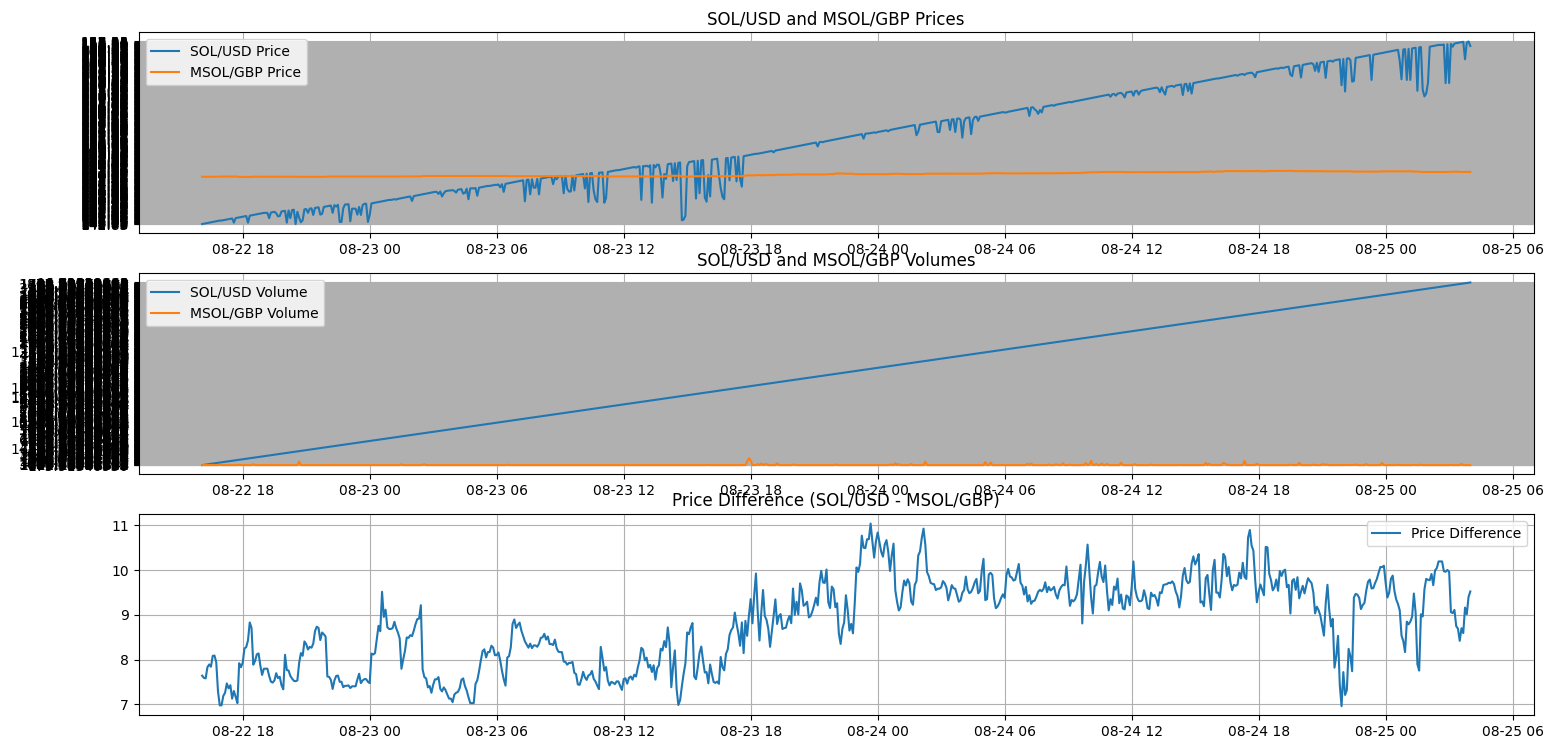

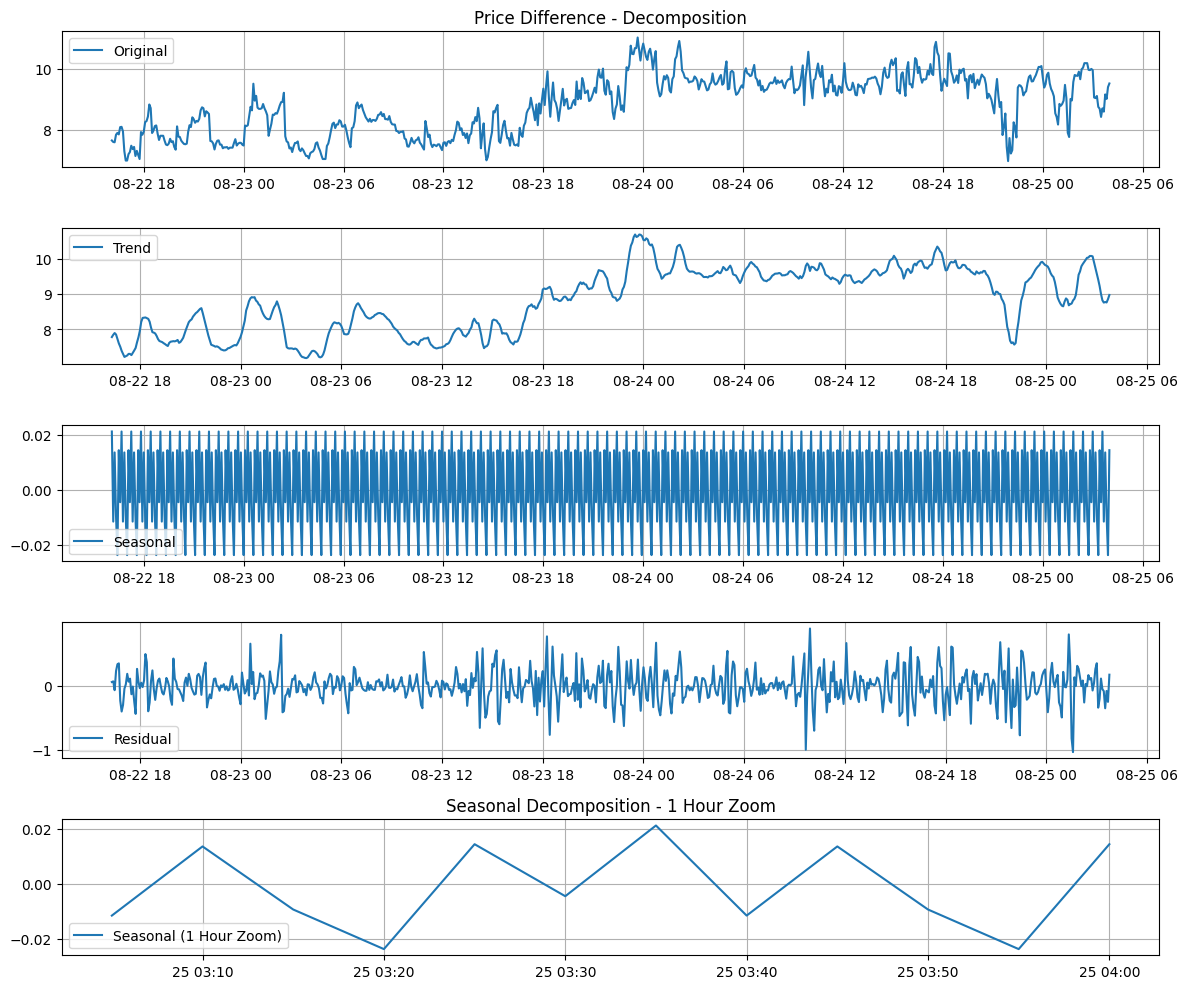

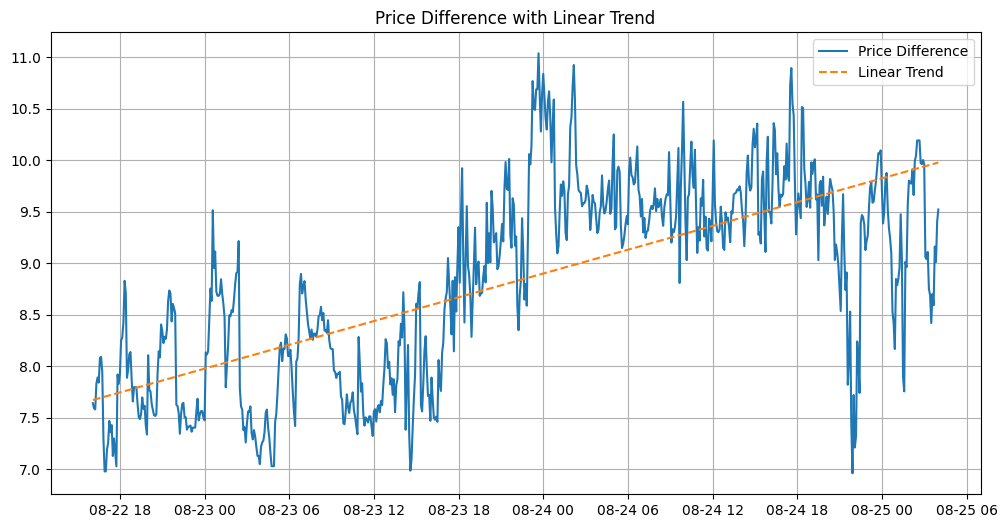

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kendalltau

# Function to fetch data from Kraken API
def fetch_kraken_data(pair):
    url = f'https://api.kraken.com/0/public/OHLC?pair={pair}&interval=5'
    response = requests.get(url)
    data = response.json()['result'][pair]
    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df[['time', 'close', 'volume']]

# Fetch SOL/USD and MSOL/USD data
solusd_data = fetch_kraken_data('SOLUSD')
msolusd_data = fetch_kraken_data('MSOLUSD')

# Convert MSOL/USD to MSOL/GBP
usd_to_gbp = 0.78  # Example conversion rate; adjust accordingly
msolusd_data['close'] = msolusd_data['close'].astype(float).round(2) * usd_to_gbp
msolusd_data['volume'] = msolusd_data['volume'].astype(float).round(2) * usd_to_gbp


# Merge datasets on time
merged_data = pd.merge(solusd_data, msolusd_data, on='time', suffixes=('_sol', '_msol'))

# Calculate differences
merged_data['price_diff'] = merged_data['close_sol'].astype(float) - merged_data['close_msol'].astype(float)
merged_data['volume_diff'] = merged_data['volume_sol'].astype(float) - merged_data['volume_msol'].astype(float)

# Plot the raw data and differences
plt.figure(figsize=(18, 12))

# Plot 1: Prices
plt.subplot(4, 1, 1)
plt.plot(merged_data['time'], merged_data['close_sol'], label='SOL/USD Price')
plt.plot(merged_data['time'], merged_data['close_msol'], label='MSOL/GBP Price')
plt.title('SOL/USD and MSOL/GBP Prices')
plt.legend()
plt.grid(True)

# Plot 2: Volumes
plt.subplot(4, 1, 2)
plt.plot(merged_data['time'], merged_data['volume_sol'], label='SOL/USD Volume')
plt.plot(merged_data['time'], merged_data['volume_msol'], label='MSOL/GBP Volume')
plt.title('SOL/USD and MSOL/GBP Volumes')
plt.legend()
plt.grid(True)



# Plot 3: Price Difference
plt.subplot(4, 1, 3)
plt.plot(merged_data['time'], merged_data['price_diff'], label='Price Difference')
plt.title('Price Difference (SOL/USD - MSOL/GBP)')
plt.legend()
plt.grid(True)
'''
# Plot 4: Moving Averages
plt.subplot(4, 1, 4)
plt.plot(merged_data['time'], merged_data['price_diff'], label='Price Difference')
plt.plot(merged_data['time'], merged_data['price_diff_sma'], label='SMA (7 Days)', linestyle='--')
plt.plot(merged_data['time'], merged_data['price_diff_ema'], label='EMA (7 Days)', linestyle='--')
plt.title('Price Difference with Moving Averages')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
'''
# Pearson Correlation
price_vol_corr = merged_data['price_diff'].corr(merged_data['volume_diff'])
print(f'Pearson Correlation between price and volume differences: {price_vol_corr}')

# ADF Test for Price Difference
adf_result = adfuller(merged_data['price_diff'].dropna())
print(f'ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}')

# Mann-Kendall Trend Test for Price Difference
tau, p_value = kendalltau(range(len(merged_data['price_diff'])), merged_data['price_diff'].dropna())
print(f'Kendall tau: {tau}, p-value: {p_value}')

# Time Series Decomposition
decomposition = seasonal_decompose(merged_data['price_diff'].dropna(), model='additive', period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition
plt.figure(figsize=(12, 10))
plt.subplot(5, 1, 1)
plt.plot(merged_data['time'], merged_data['price_diff'], label='Original')
plt.title('Price Difference - Decomposition')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(merged_data['time'], trend, label='Trend')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(merged_data['time'], seasonal, label='Seasonal')
plt.legend()
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(merged_data['time'], residual, label='Residual')
plt.legend()
plt.grid(True)

# One-hour zoom on the seasonal decomposition
one_hour_data = merged_data.tail(12)  # Assuming 5-minute intervals, 12 data points for 1 hour
one_hour_seasonal = seasonal.tail(12)
plt.subplot(5, 1, 5)
plt.plot(one_hour_data['time'], one_hour_seasonal, label='Seasonal (1 Hour Zoom)')
plt.title('Seasonal Decomposition - 1 Hour Zoom')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Linear Regression for trend detection
x = np.array(range(len(merged_data.dropna()))).reshape(-1, 1)
y = merged_data['price_diff'].dropna().values

# trim longer array
if len(x) > len(y):
    x = x[:len(y)]
elif len(y) > len(X):
    y = y[:len(x)]
model = LinearRegression().fit(x, y)
merged_data['price_diff_trend'] = model.predict(x)

# Plot Linear Regression Trend
plt.figure(figsize=(12, 6))
plt.plot(merged_data['time'], merged_data['price_diff'], label='Price Difference')
plt.plot(merged_data['time'], merged_data['price_diff_trend'], label='Linear Trend', linestyle='--')
plt.title('Price Difference with Linear Trend')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import requests

url = "https://api.kraken.com/0/public/Depth?pair=SOLGBP"

payload = {}
headers = {
  'Accept': 'application/json'
}

response = requests.request("GET", url, headers=headers, data=payload)

print(response.text)

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Kraken API endpoint
BASE_URLK = 'https://api.kraken.com/0/public/OHLC'

# Function to fetch historical data from Kraken
def fetch_hist_data_kraken(pair, interval, since):
    url = f"{BASE_URLK}?pair={pair}&interval={interval}&since={since}"
    headers = {
        'Accept': 'application/json'
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    if 'error' in data and data['error']:
        print(f"Error fetching data for {pair}: {data['error']}")
        return pd.DataFrame()
    result = data['result']
    pair_key = list(result.keys())[0]
    return pd.DataFrame(result[pair_key], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

# Define the time ranges (1 day)
end = datetime.utcnow()
start = end - timedelta(days=1)
since = int(start.timestamp())

# Define the USD to GBP conversion rate
USD_TO_GBP_RATE = 0.73  # Example conversion rate

# Fetch the data for SOL-GBP and MSOL-USD for the last day
sol_data = fetch_hist_data_kraken("SOLGBP", 1440, since)  # 1440 corresponds to daily candles
msol_data = fetch_hist_data_kraken("MSOLUSD", 1440, since)  # 1440 corresponds to daily candles

# Check if data is fetched correctly
if sol_data.empty or msol_data.empty:
    print("Failed to fetch data for one or both products.")
else:
    # Convert 'time' column to datetime
    sol_data['time'] = pd.to_datetime(sol_data['time'], unit='s')
    msol_data['time'] = pd.to_datetime(msol_data['time'], unit='s')

    # Convert USD prices to GBP
    msol_data['close'] = msol_data['close'].astype(float) * USD_TO_GBP_RATE

    # Truncate price values to 2 decimal places
    sol_data['close'] = sol_data['close'].astype(float).round(2)
    msol_data['close'] = msol_data['close'].astype(float).round(2)

    # Calculate the difference in closing prices
    data = pd.merge(sol_data[['time', 'close']], msol_data[['time', 'close']], on='time', suffixes=('_sol', '_msol'))
    data['price_difference'] = data['close_sol'] - data['close_msol']

    # Plot the data in subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subplot 1: SOL vs mSOL Prices
    axs[0].plot(data['time'], data['close_sol'], label='SOL Price (GBP)', color='red', linewidth=2)
    axs[0].plot(data['time'], data['close_msol'], label='mSOL Price (GBP)', color='black', linewidth=2)
    axs[0].set_title('SOL vs mSOL Prices Over the Last Day')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price (GBP)')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Price Difference
    axs[1].plot(data['time'], data['price_difference'], label='Price Difference (SOL - mSOL)', color='blue', linewidth=2)
    axs[1].set_title('SOL vs mSOL Price Difference Over the Last Day')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price Difference (GBP)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Coinbase API endpoint
BASE_URLC = 'https://api.pro.coinbase.com'

headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "CB-ACCESS-KEY": "MY_API_KEY"
}

# Function to fetch transaction blocks from Coinbase
def fetch_transactions(product_id, start, end):
    url = f"{BASE_URLC}/products/{product_id}/trades"
    params = {
        "start": start,
        "end": end
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        print(f"No data fetched for {product_id}")
        return pd.DataFrame()
    return pd.DataFrame(data)

# Define the time range (past week)
end = datetime.utcnow()
start = end - timedelta(days=7)

# Fetch the transaction blocks for SOL-USD for the past week
transactions = fetch_transactions("SOL-USD", start.isoformat(), end.isoformat())

# Check if data is fetched correctly
if transactions.empty:
    print("Failed to fetch transaction data.")
else:
    # Convert 'time' column to datetime
    transactions['time'] = pd.to_datetime(transactions['time'])

    # Resample data to daily frequency and calculate total volume and average price
    transactions.set_index('time', inplace=True)
    daily_data = transactions.resample('D').apply({
        'size': 'sum',
        'price': lambda x: (x.astype(float) * transactions.loc[x.index, 'size'].astype(float)).sum() / transactions.loc[x.index, 'size'].astype(float).sum()
    }).rename(columns={'size': 'total_volume', 'price': 'average_price'})

    # Plot the data
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Subplot 1: Total Volume
    axs[0].plot(daily_data.index, daily_data['total_volume'], label='Total Volume', color='blue')
    axs[0].set_title('Total Volume of SOL-USD Transactions Over the Past Week')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Total Volume')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Average Price
    axs[1].plot(daily_data.index, daily_data['average_price'], label='Average Price', color='green')
    axs[1].set_title('Average Price of SOL-USD Transactions Over the Past Week')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Average Price (USD)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
    